# Sampling standard Gaussian random variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm # To access the CDF of the standard Gaussian distribution

Throughout this tutorial, we are only allowed to use Numpy's random number generator to sample uniform random variables.

In [2]:
def Unif():
  return np.random.uniform()

In [3]:
Unif()

0.27943576228382394

The purpose of the tutorial is merely to implement the Box--Muller and Ziggurat algorithms, we will not try to optimise their efficiency.

## 1. The Box--Muller method

We recall that the Box--Muller method is based on the remark that if $(U_1, U_2)$ are independent $\mathcal{U}[0,1]$ variables, then
$$X_1 = \sqrt{-2\log(U_1)} \cos(2\pi U_2), \qquad X_2 = \sqrt{-2\log(U_1)} \sin(2\pi U_2),$$
are independent $\mathcal{N}(0,1)$ variables.

Complete the function `BoxMuller()` so that it returns the variable $X_1$ as above.

In [4]:
def BoxMuller():
  U1 = Unif()
  U2 = Unif()
  return (-2*np.log(U1))**.5*np.sin(2*math.pi*U2)

In [5]:
BoxMuller()

0.25125458138828327

We check the validity of the function `BoxMuller()` by plotting the histogram of 1000 realisations together with the density of the $\mathcal{N}(0,1)$ law.

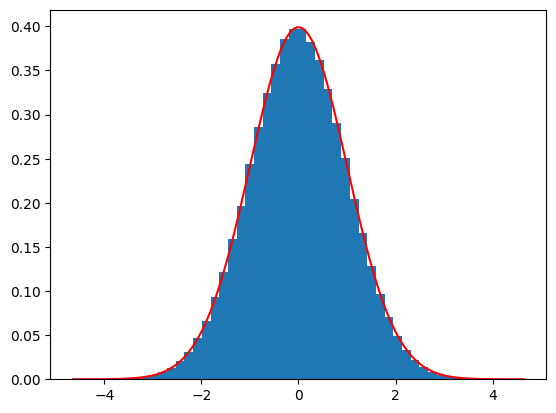

In [40]:
# Sample
N = 5000
Sample = np.zeros(N)
for k in range(N):
  Sample[k] = BoxMuller()

plt.hist(Sample, bins=50, density=True)

# Theoretical density
x_max = max(abs(Sample))
xx = np.linspace(-x_max, x_max, 500)
den = np.exp(-xx**2/2)/(2*math.pi)**.5

plt.plot(xx,den,color='red')

plt.show()

## 2. The Ziggurat algorithm

This is adapted from Wikipedia's page on the [Ziggurat algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm), which was published in 2000.

The algorithm primarily generates a positive random variable $X'$ distributed as $|X|$ with $X \sim \mathcal{N}(0,1)$, so that $X'$ has density
$$\sqrt{\frac{2}{\pi}} \exp\left(-\frac{x^2}{2}\right)$$
on $[0,+\infty)$.

To generate a realisation of $X$ from a realisation of $X'$ you may use the following function.

In [7]:
def RandomSign(x):
  return (1-2*(Unif()<.5))*x

The Ziggurat algorithm does not depend on the density of $X'$ being normalised so we set
$$f(x) = \exp\left(-\frac{x^2}{2}\right).$$

In [8]:
def f(x):
  return np.exp(-x**2/2)

y_max = f(0)

def f_inv(y): # inverse function
  return (-2*np.log(y))**.5

### 1. Precomputing the ziggurat

It may help to have in mind what a [ziggurat](https://en.wikipedia.org/wiki/Ziggurat) actually is.

The basis of the Ziggurat algorithm consists in covering the graph of $f$ with a predefined number $n$ of horizontal layers defined as follows.

The base is defined as all points inside the distribution and below $y_1 = f(x_1)$. This consists of a rectangular region from $(0, 0)$ to $(x_1, y_1)$, and the (infinite) tail of the distribution, where $x > x_1$ (and $y < y_1$).

This layer (call it layer $0$) has area $A$. On top of this, add a rectangular layer of width $x_1$ and height $A/x_1$, so it also has area $A$. The top of this layer is at height $y_2 = y_1 + A/x_1$, and intersects the density function at a point $(x_2, y_2)$, where $y_2 = f(x_2)$. This layer includes every point in the density function between $y_1$ and $y_2$, but (unlike the base layer) also includes points such as $(x_1, y_2)$ which are not in the distribution. Further layers are then stacked on top, until $y_n > y_\mathrm{max} = f(0)$ in which case we set $x_n=0$.

The following function takes $x_1$ as an argument and returns a pair $(x,y)$ with $x$ and $y$ are two lists which respectively contain $(x_1, \ldots, x_n)$ and $(y_1, \ldots, y_n)$.

In [9]:
def layers(x1):
  y1 = f(x1)
  A = x1*y1 + (2*math.pi)**.5*(1-norm.cdf(x1))

  x_c = x1 #current x_i
  y_c = y1 #current y_i
  y_n = y_c + A/x_c #next y_i

  x = [x_c]
  y = [y_c]
  while (y_n < y_max):
    y_c = y_n
    x_c = f_inv(y_c)
    x.append(x_c)
    y.append(y_c)

    y_n = y_c + A/x_c

  x.append(0)
  y.append(y_n)

  return [x,y]

The covering of $f$ by the ziggurat is visualised as follows.

Number of layers: 11


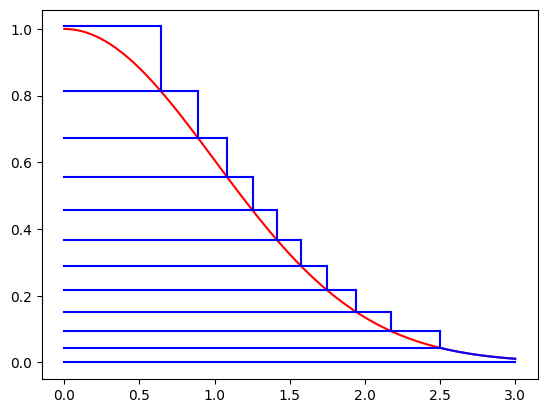

In [22]:
x1 = 2.5
plt.plot(np.linspace(0,1.2*x1,100),f(np.linspace(0,1.2*x1,100)),color='red')

[x,y] = layers(x1)
n = len(x)


plt.plot([0,1.2*x1],[0,0],color='blue')
plt.plot([0,x[0]],[y[0],y[0]],color='blue')
plt.plot(np.linspace(x1,1.2*x1,20),f(np.linspace(x1,1.2*x1,20)),color='blue')

for i in range(n-1):
  plt.plot([x[i],x[i]],[y[i],y[i+1]],color='blue')
  plt.plot([0,x[i]],[y[i+1],y[i+1]],color='blue')

print("Number of layers:", n)

### 2. Rejection sampling

To sample from the (normalised) ziggurat, we first draw a layer $i \in \{0, \ldots, n-1\}$ uniformly. Then we draw a point $(x,y)$ uniformly in the layer with the following algorithm.

* If $i \geq 1$, the layer is a rectangle. We first draw $x$ uniformly in $[0,x_i]$. If $x \leq x_{i+1}$ then whatever the choice of $y$ the point $(x,y)$ will be below the graph of $f$ so there is no actual need to generate $y$ and we may return $X=x$ directly. If $x \in (x_{i+1}, x_i]$, then we draw $y$ uniformly in $[y_i,y_{i+1}]$. If $y \leq f(x)$ then we return $X=x$ ortherwise we reject the draw and restart from the beginning.

* If $i=0$, we first define $x_0 = A/y_1 > x_1$ and draw $x$ uniformly on $[0,x_0]$. If $x \leq x_1$ then we return $X=x$. Otherwise we need to draw $X$ in the tail of the distribution, namely according to the distribution $$\frac{f(x)1_{x>x_1}}{\int f(x)1_{x>x_1} dx}.$$ To do so we use the following *fallback algorithm*: let $x'=-\log(U_1)/x_1$, $y'=-\log(U_2)$; if $2y'>x'^2$ return $X=x'+x_1$ otherwise reject.

Implement this algorithm in the next function.

In [34]:
x1 = 3.5
[x,y] = layers(x1)
n = len(x)

def Ziggurat():
  while True:
    i = math.floor(n*Unif())
    if (i>=1):
      X = x[i-1]*Unif()
      if (X<=x[i]):
        return X
      else:
        Y = y[i-1] + (y[i]-y[i-1])*Unif()
        if (Y < f(X)):
          return X
    else:
      A = x[0]*(y[1]-y[0])
      x0 = A/y[0]
      X = x0*Unif()
      if (X<=x[0]):
        return X
      else:
        X = -np.log(Unif())/x[0]
        Y = -np.log(Unif())
        if (2*Y>X**2):
          return X+x[0]

In [31]:
Ziggurat()

0.1964378888490481

We draw the associated histogram.

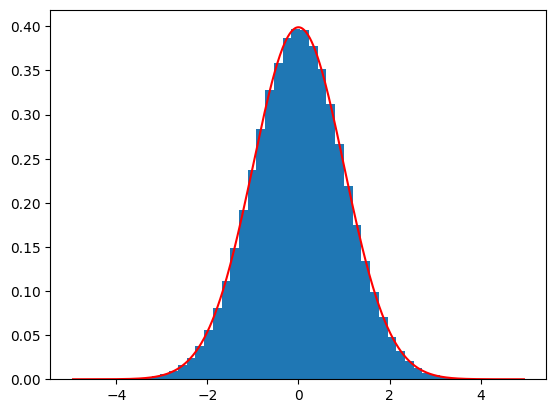

In [41]:
# Sample
N = 5000
Sample = np.zeros(N)
for k in range(N):
  Sample[k] = RandomSign(Ziggurat())

plt.hist(Sample, bins=50, density=True)

# Theoretical density
x_max = max(abs(Sample))
xx = np.linspace(-x_max, x_max, 500)
den = np.exp(-xx**2/2)/(2*math.pi)**.5

plt.plot(xx,den,color='red')

plt.show()